# Working with FBI crime data: 2014 - 2018

## Nick Webb (webbn@union.edu) / March, 2020
## HACKATHON Tutorial

In this Jupyter notebook we are going to explore elements of the FBI crime data for the years 2014 - 2018. We have chosen to focus on crimes committed on University and College campuses, in the NY state region. 

All data was obtained from: https://ucr.fbi.gov/crime-in-the-u.s/

This notebook was then exported as a web page (.html) for easy viewing. 

TODO:
- Host files on git?
- Clean data output
- MAP data: https://stackoverflow.com/questions/7586384/color-states-with-pythons-matplotlib-basemap
- BETTER - use plotly (or other online resource). Pull a polygon map. Color it. 

### Crimes at Colleges and Universities: 2104 Data Analysis

We're using the following libraries in Python:
- pandas (for data manipulation): https://pandas.pydata.org/
- matplotlib (for plotting): https://matplotlib.org/
- scikit learn (for regression): https://scikit-learn.org/stable/

The whole document is a Jupyter notebook: https://jupyter.org/

Jupyter is a browser based interactive environment for coding. In this case we are using Python 3. 
Any cell marked
- In [*]: 

represents a cell of Python code. 

Any cell marked 
- Out [*]: 

represents the output of the previous cell, including graphs, tables and basic output.



We start with just the crime data for 2014.

We've downloaded the data to a local directory. Below we load it, and put it into a readable format (removing blank lines, and formatting the column headings).

We then show some basic details, and display the first 5 records in the data.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt


# Read in the excel spreadsheet
# Skip the first two rows
# Set the next row as the column headers

df_2014 = pd.read_excel('Table_9_Offenses_Known_to_Law_Enforcement_by_State_by_University_and_College_2014.xls',header=1, skiprows=2)


# Get some details about how much data there is

r, c = df_2014.shape
print('There are',r,'rows and',c,'columns in this data')


# Adjust the column headings to something more uniform
# Used print(df_2014.columns.values.tolist())
# to show original headings

df_2014.columns = df_2014.columns.str.strip().str.lower().str.replace('\n',' ').str.replace(' ', '_').str.replace('(', '').str.replace(')', '')
 

# Show data at this point

df_2014.head()


There are 663 rows and 15 columns in this data


,state,university/college,campus,student_enrollment1,violent_crime,murder_and_nonnegligent_manslaughter,rape_revised_definition2,rape_legacy_definition3,robbery,aggravated_assault,property_crime,burglary,larceny-_theft,motor_vehicle_theft,arson4
0,ALABAMA,Jacksonville State University,NaN,8693.0,1.0,0.0,0.0,NaN,0.0,1.0,61.0,11.0,49.0,1.0,NaN
1,NaN,Jefferson State Community College,NaN,8542.0,0.0,0.0,0.0,NaN,0.0,0.0,31.0,1.0,29.0,1.0,NaN
2,NaN,Samford University,NaN,4833.0,1.0,0.0,0.0,NaN,0.0,1.0,39.0,1.0,37.0,1.0,NaN
3,NaN,Troy University,NaN,20573.0,6.0,0.0,0.0,NaN,0.0,6.0,120.0,23.0,91.0,6.0,NaN
4,NaN,Tuskegee University,NaN,3118.0,16.0,0.0,5.0,NaN,3.0,8.0,173.0,16.0,150.0,7.0,NaN


This data is really pretty clean, but there are still things to deal with. There are NaN (missing value) markers that need replacing. There are also some random characters (5, for instance) in the names of colleges and universities. What follows is some classic data wrangling, cleaning stuff up and getting a sense of the data. First we deal with nationwide data, and then we'll focus on data just from New York state.

In [2]:
# Fill in missing (NaN) data values

# Start with state, and forward fill (ffill) with previous values
# Also forward fill University/College
# Replace NaN in campus with the word main
# THEN replace campus name with university/college + campus name (Plan to use the campus column for filtering)
# Replace all other NaN with 0.0

df_2014['state'].fillna(method='ffill',inplace=True)
df_2014['university/college'].fillna(method='ffill',inplace=True)
df_2014['campus'].fillna('main',inplace=True)
df_2014['campus'] = df_2014['university/college'] + ' ' + df_2014['campus']
df_2014.fillna(0,inplace=True)

# Show results

df_2014.head()


,state,university/college,campus,student_enrollment1,violent_crime,murder_and_nonnegligent_manslaughter,rape_revised_definition2,rape_legacy_definition3,robbery,aggravated_assault,property_crime,burglary,larceny-_theft,motor_vehicle_theft,arson4
0,ALABAMA,Jacksonville State University,Jacksonville State University main,8693.0,1.0,0.0,0.0,0.0,0.0,1.0,61.0,11.0,49.0,1.0,0.0
1,ALABAMA,Jefferson State Community College,Jefferson State Community College main,8542.0,0.0,0.0,0.0,0.0,0.0,0.0,31.0,1.0,29.0,1.0,0.0
2,ALABAMA,Samford University,Samford University main,4833.0,1.0,0.0,0.0,0.0,0.0,1.0,39.0,1.0,37.0,1.0,0.0
3,ALABAMA,Troy University,Troy University main,20573.0,6.0,0.0,0.0,0.0,0.0,6.0,120.0,23.0,91.0,6.0,0.0
4,ALABAMA,Tuskegee University,Tuskegee University main,3118.0,16.0,0.0,5.0,0.0,3.0,8.0,173.0,16.0,150.0,7.0,0.0


Now we have some data in usable format, let's take a look at some statistics. We'll compute the total number of violent crimes in the data, and the total in NY state for 2014

In [3]:
# Compute amount of violent crimes nationwide, and for NYS

violent_total = df_2014['violent_crime'].sum()
print('Violent Crime Total:',violent_total)

nys_violent_total = df_2014.loc[df_2014['state'] == "NEW YORK", 'violent_crime'].sum()
print('NYS Violent Crime Total:',nys_violent_total)

Violent Crime Total: 3166.0
NYS Violent Crime Total: 52.0


In [1]:
from mpl_toolkits.basemap import Basemap
from matplotlib.patches import Polygon

ModuleNotFoundError: No module named 'mpl_toolkits.basemap'

Next, we cut out just the NY state data, and also do some fixing of formatting. We show how much data that leaves us with.

In [4]:
# Let's focus on NYS for now. 
# Create a new dataframe with just NY data

nys_df_2014 = df_2014.loc[df_2014['state'] == "NEW YORK"].copy()
nys_df_2014['campus'] = nys_df_2014['campus'].str.replace('5','')

nys_df_2014.head()


,state,university/college,campus,student_enrollment1,violent_crime,murder_and_nonnegligent_manslaughter,rape_revised_definition2,rape_legacy_definition3,robbery,aggravated_assault,property_crime,burglary,larceny-_theft,motor_vehicle_theft,arson4
366,NEW YORK,Cornell University5,Cornell University main,21593.0,4.0,0.0,1.0,0.0,0.0,3.0,231.0,21.0,210.0,0.0,0.0
367,NEW YORK,Ithaca College,Ithaca College main,6723.0,1.0,0.0,0.0,0.0,1.0,0.0,107.0,18.0,87.0,2.0,0.0
368,NEW YORK,State University of New York:,State University of New York: Binghamton,16077.0,1.0,0.0,1.0,0.0,0.0,0.0,213.0,17.0,196.0,0.0,1.0
369,NEW YORK,State University of New York:,State University of New York: Buffalo,29850.0,5.0,0.0,3.0,0.0,0.0,2.0,315.0,25.0,288.0,2.0,0.0
370,NEW YORK,State University of New York:,State University of New York: Downstate Medic...,1865.0,0.0,0.0,0.0,0.0,0.0,0.0,63.0,0.0,63.0,0.0,0.0


In [5]:
# See how much data that leaves us with

r, c = nys_df_2014.shape
print('There are',r,'rows and',c,'columns in this data')

There are 29 rows and 15 columns in this data


We have extracted 29 rows of NY data. We ADD a column, which represents the number of violent crimes per 1000 registered students at each college. We also going to calculate the mean, median, min and max values for this new score, and pull the row for the entry with the maximum value. 

It's worth remembering that because violent crime is so rare, small increases cause significant impact. The record pulled for the upstate medical center in Syracuse has such a high proportion because in 2014 there were TWO violent crimes, for a population of just over 1500. 

At the end of this section, we'll graph the proportion of crimes per 1000 students across the 2014 NY state data

In [6]:
# Add a new column to our dataframe, that calculates the number
# of violent crimes per 1000 student enrollments

nys_df_2014['violent_crime_per_1000'] =  (nys_df_2014['violent_crime'] / (nys_df_2014['student_enrollment1'] / 1000) )
nys_df_2014.head()

,state,university/college,campus,student_enrollment1,violent_crime,murder_and_nonnegligent_manslaughter,rape_revised_definition2,rape_legacy_definition3,robbery,aggravated_assault,property_crime,burglary,larceny-_theft,motor_vehicle_theft,arson4,violent_crime_per_1000
366,NEW YORK,Cornell University5,Cornell University main,21593.0,4.0,0.0,1.0,0.0,0.0,3.0,231.0,21.0,210.0,0.0,0.0,0.185245
367,NEW YORK,Ithaca College,Ithaca College main,6723.0,1.0,0.0,0.0,0.0,1.0,0.0,107.0,18.0,87.0,2.0,0.0,0.148743
368,NEW YORK,State University of New York:,State University of New York: Binghamton,16077.0,1.0,0.0,1.0,0.0,0.0,0.0,213.0,17.0,196.0,0.0,1.0,0.062201
369,NEW YORK,State University of New York:,State University of New York: Buffalo,29850.0,5.0,0.0,3.0,0.0,0.0,2.0,315.0,25.0,288.0,2.0,0.0,0.167504
370,NEW YORK,State University of New York:,State University of New York: Downstate Medic...,1865.0,0.0,0.0,0.0,0.0,0.0,0.0,63.0,0.0,63.0,0.0,0.0,0.000000


In [7]:

mean_vcp_2014 = nys_df_2014['violent_crime_per_1000'].mean()
median_vcp_2014 = nys_df_2014['violent_crime_per_1000'].median()
max_vc = nys_df_2014['violent_crime_per_1000'].max()
min_vc = nys_df_2014['violent_crime_per_1000'].min()

print('For NYS, mean average crime per 1000 is',mean_vcp_2014,'( median:',median_vcp_2014,')')
print('MAX:',max_vc,'and MIN:',min_vc)
print()
print('The row with highest violent crime per 1000 people is:\n\n',nys_df_2014.loc[nys_df_2014['violent_crime_per_1000'].idxmax()])

For NYS, mean average crime per 1000 is 0.2803542128782464 ( median: 0.1675041876046901 )
MAX: 1.2368583797155226 and MIN: 0.0

The row with highest violent crime per 1000 people is:

 state                                                                            NEW YORK
university/college                                         State University of New York: 
campus                                  State University of New York:  Upstate Medical...
student_enrollment1                                                                  1617
violent_crime                                                                           2
murder_and_nonnegligent_manslaughter                                                    0
rape_revised_definition2                                                                0
rape_legacy_definition3                                                                 0
robbery                                                                                 1
aggra

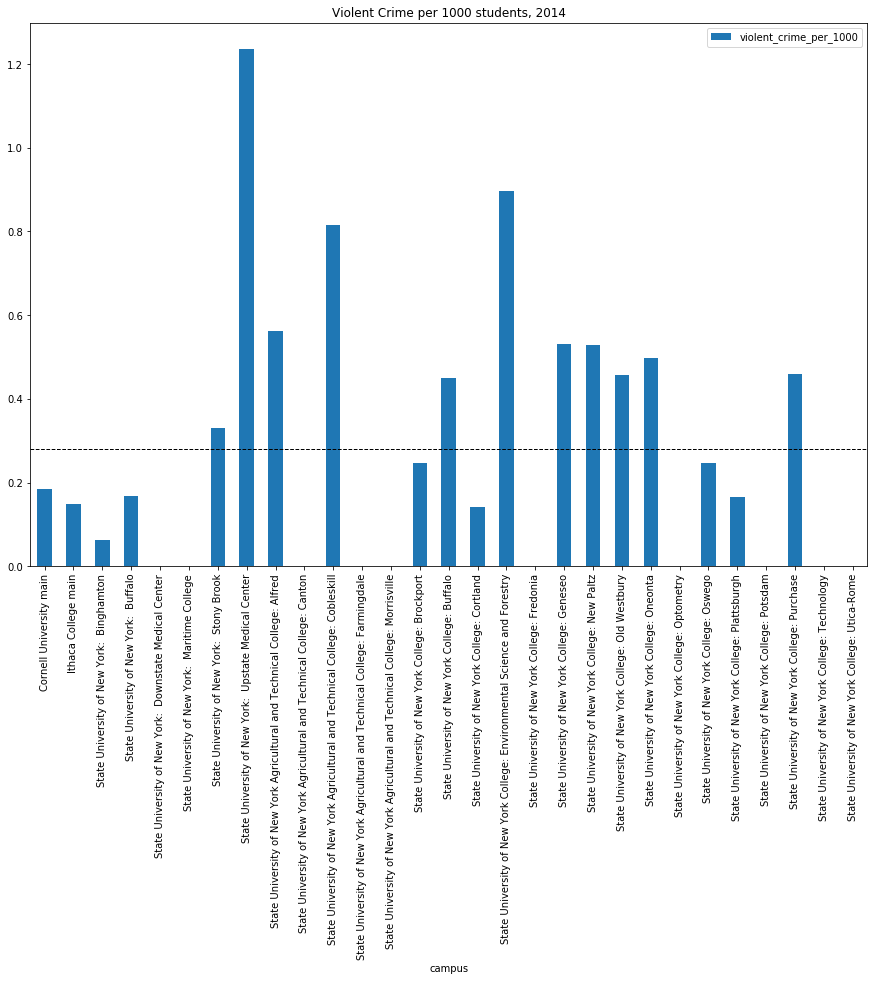

In [8]:
nys_df_2014.plot.bar(x='campus', y='violent_crime_per_1000', rot=0,figsize=(15,10))
plt.title('Violent Crime per 1000 students, 2014')
plt.axhline(y=mean_vcp_2014,linewidth=1, color='k', linestyle='--')
plt.xticks(rotation=90)
plt.show()

So far we've just looked at 2014 data. What about the next 4 years (2015 - 2018). We present this below, a year at a time, without the commentary above. 

### 2015 Data Analysis

There are 688 rows and 19 columns in the 2015 FULL data
There are 30 rows and 20 columns in the 2015 NYS data
For NYS, mean average crime per 1000 is 0.48503995239812686 ( median: 0.34343534691860683 )
MAX: 2.1447721179624666 and MIN: 0.0



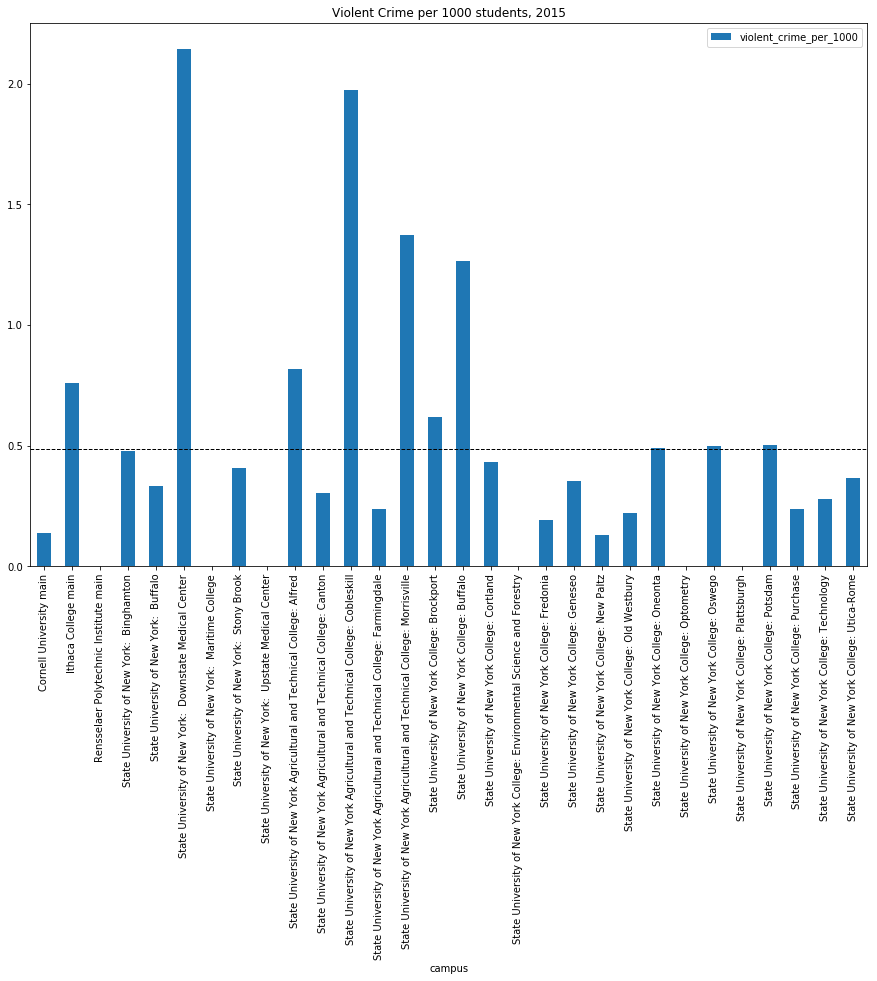

In [9]:
df_2015 = pd.read_excel('Table_9_Offenses_Known_to_Law_Enforcement_by_State_by_University_and_College_2015.xls',header=1, skiprows=2)
r, c = df_2015.shape
print('There are',r,'rows and',c,'columns in the 2015 FULL data')

df_2015.columns = df_2015.columns.str.strip().str.lower().str.replace('\n',' ').str.replace(' ', '_').str.replace('(', '').str.replace(')', '')

df_2015['state'].fillna(method='ffill',inplace=True)
df_2015['university/college'].fillna(method='ffill',inplace=True)
#df_2015['campus'].fillna(df_2015['university/college'],inplace=True)
df_2015['campus'].fillna('main',inplace=True)
df_2015['campus'] = df_2015['university/college'] + ' ' + df_2015['campus']
df_2015.fillna(0,inplace=True)

nys_df_2015 = df_2015.loc[df_2015['state'] == "NEW YORK"].copy()
nys_df_2015['campus'] = nys_df_2015['campus'].str.replace('5','')

nys_df_2015['violent_crime_per_1000'] =  (nys_df_2015['violent_crime'] / (nys_df_2015['student_enrollment1'] / 1000) )

r, c = nys_df_2015.shape
print('There are',r,'rows and',c,'columns in the 2015 NYS data')

mean_vcp_2015 = nys_df_2015['violent_crime_per_1000'].mean()
median_vcp_2015 = nys_df_2015['violent_crime_per_1000'].median()
max_vc = nys_df_2015['violent_crime_per_1000'].max()
min_vc = nys_df_2015['violent_crime_per_1000'].min()

print('For NYS, mean average crime per 1000 is',mean_vcp_2015,'( median:',median_vcp_2015,')')
print('MAX:',max_vc,'and MIN:',min_vc)
print()
#print('The row with highest violent crime per 1000 people is:\n\n',nys_df_2015.loc[nys_df_2015['violent_crime_per_1000'].idxmax()])

nys_df_2015.plot.bar(x='campus', y='violent_crime_per_1000', rot=0,figsize=(15,10))
plt.axhline(y=mean_vcp_2015,linewidth=1, color='k', linestyle='--')

plt.title('Violent Crime per 1000 students, 2015')
plt.xticks(rotation=90)
plt.show()

### 2016 Data Analysis

There are 695 rows and 15 columns in the 2016 FULL data
There are 27 rows and 16 columns in the 2016 NYS data
For NYS, mean average crime per 1000 is 0.6147384867211101 ( median: 0.5321350440489564 )
MAX: 1.7424975798644724 and MIN: 0.0



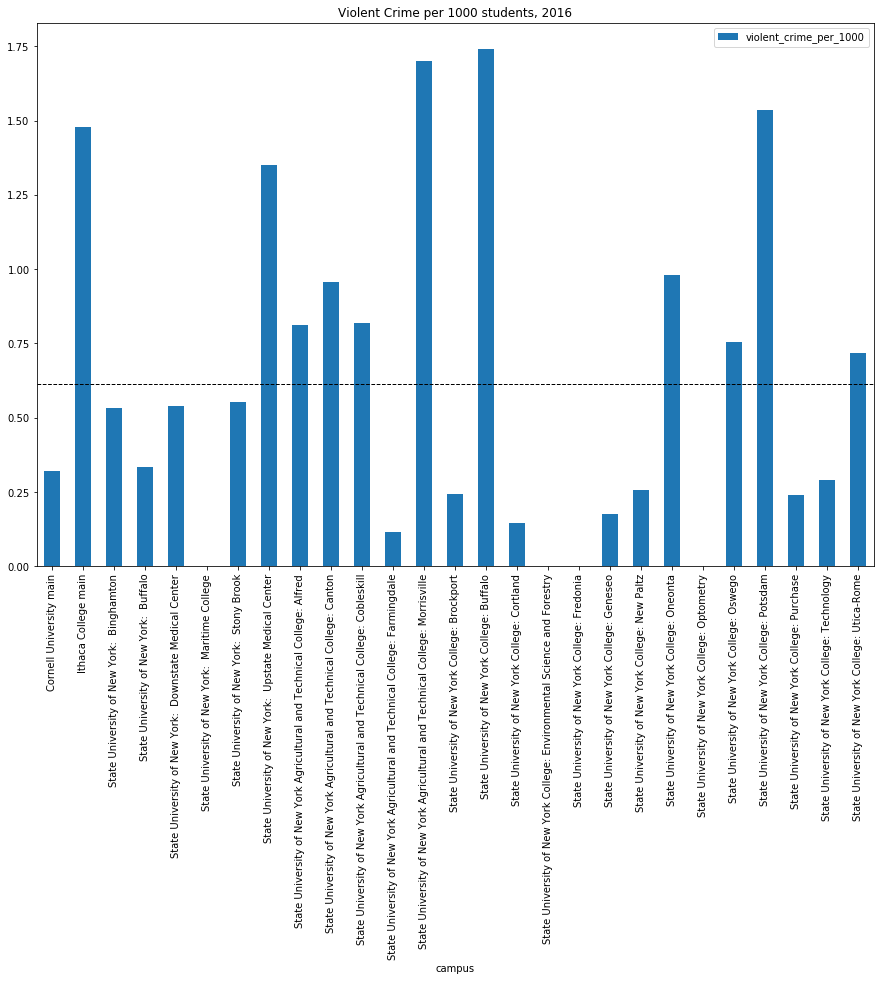

In [10]:
df_2016 = pd.read_excel('Table_7_Offenses_Known_to_Law_Enforcement_by_State_by_University_and_College_2016.xls',header=1, skiprows=2)
r, c = df_2016.shape
print('There are',r,'rows and',c,'columns in the 2016 FULL data')

df_2016.columns = df_2016.columns.str.strip().str.lower().str.replace('\n',' ').str.replace(' ', '_').str.replace('(', '').str.replace(')', '')

df_2016['state'].fillna(method='ffill',inplace=True)
df_2016['university/college'].fillna(method='ffill',inplace=True)
df_2016['campus'].fillna('main',inplace=True)
df_2016['campus'] = df_2016['university/college'] + ' ' + df_2016['campus']
df_2016.fillna(0,inplace=True)

nys_df_2016 = df_2016.loc[df_2016['state'] == "NEW YORK"].copy()
nys_df_2016['campus'] = nys_df_2016['campus'].str.replace('5','')

nys_df_2016['violent_crime_per_1000'] =  (nys_df_2016['violent_crime'] / (nys_df_2016['student_enrollment1'] / 1000) )

r, c = nys_df_2016.shape
print('There are',r,'rows and',c,'columns in the 2016 NYS data')

mean_vcp_2016 = nys_df_2016['violent_crime_per_1000'].mean()
median_vcp_2016 = nys_df_2016['violent_crime_per_1000'].median()
max_vc = nys_df_2016['violent_crime_per_1000'].max()
min_vc = nys_df_2016['violent_crime_per_1000'].min()

print('For NYS, mean average crime per 1000 is',mean_vcp_2016,'( median:',median_vcp_2016,')')
print('MAX:',max_vc,'and MIN:',min_vc)
print()
#print('The row with highest violent crime per 1000 people is:\n\n',nys_df_2016.loc[nys_df_2016['violent_crime_per_1000'].idxmax()])

nys_df_2016.plot.bar(x='campus', y='violent_crime_per_1000', rot=0,figsize=(15,10))
plt.axhline(y=mean_vcp_2016,linewidth=1, color='k', linestyle='--')

plt.title('Violent Crime per 1000 students, 2016')
plt.xticks(rotation=90)
plt.show()

### 2017 Data Analysis

There are 666 rows and 14 columns in the 2017 FULL data
There are 29 rows and 15 columns in the 2017 NYS data
For NYS, mean average crime per 1000 is 0.699911508138912 ( median: 0.46264168401572975 )
MAX: 3.4980323567993006 and MIN: 0.0



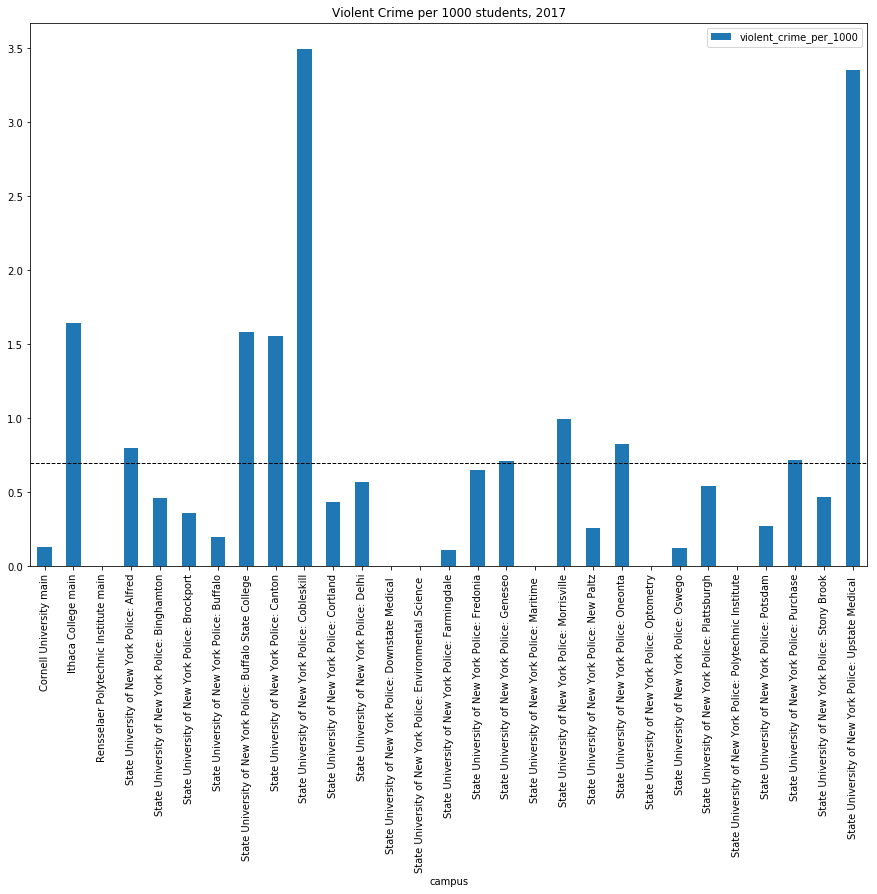

In [11]:
df_2017 = pd.read_excel('Table_9_Offenses_Known_to_Law_Enforcement_by_State_by_University_and_College_2017.xls',header=1, skiprows=2)
r, c = df_2017.shape
print('There are',r,'rows and',c,'columns in the 2017 FULL data')

df_2017.columns = df_2017.columns.str.strip().str.lower().str.replace('\n',' ').str.replace(' ', '_').str.replace('(', '').str.replace(')', '')

df_2017['state'].fillna(method='ffill',inplace=True)
df_2017['university/college'].fillna(method='ffill',inplace=True)
#df_2017['campus'].fillna(df_2017['university/college'],inplace=True)
df_2017['campus'].fillna('main',inplace=True)
df_2017['campus'] = df_2017['university/college'] + ' ' + df_2017['campus']
df_2017.fillna(0,inplace=True)

nys_df_2017 = df_2017.loc[df_2017['state'] == "NEW YORK"].copy()
nys_df_2017['campus'] = nys_df_2017['campus'].str.replace('5','')

nys_df_2017['violent_crime_per_1000'] =  (nys_df_2017['violent_crime'] / (nys_df_2017['student_enrollment1'] / 1000) )

r, c = nys_df_2017.shape
print('There are',r,'rows and',c,'columns in the 2017 NYS data')

mean_vcp_2017 = nys_df_2017['violent_crime_per_1000'].mean()
median_vcp_2017 = nys_df_2017['violent_crime_per_1000'].median()
max_vc = nys_df_2017['violent_crime_per_1000'].max()
min_vc = nys_df_2017['violent_crime_per_1000'].min()

print('For NYS, mean average crime per 1000 is',mean_vcp_2017,'( median:',median_vcp_2017,')')
print('MAX:',max_vc,'and MIN:',min_vc)
print()
#print('The row with highest violent crime per 1000 people is:\n\n',nys_df_2017.loc[nys_df_2017['violent_crime_per_1000'].idxmax()])

nys_df_2017.plot.bar(x='campus', y='violent_crime_per_1000', rot=0,figsize=(15,10))
plt.axhline(y=mean_vcp_2017,linewidth=1, color='k', linestyle='--')

plt.title('Violent Crime per 1000 students, 2017')
plt.xticks(rotation=90)
plt.show()

### 2018 Data Analysis

There are 645 rows and 14 columns in the 2018 FULL data
There are 26 rows and 15 columns in the 2018 NYS data
For NYS, mean average crime per 1000 is 0.5479140818125268 ( median: 0.2756866790049643 )
MAX: 4.427577482605946 and MIN: 0.0



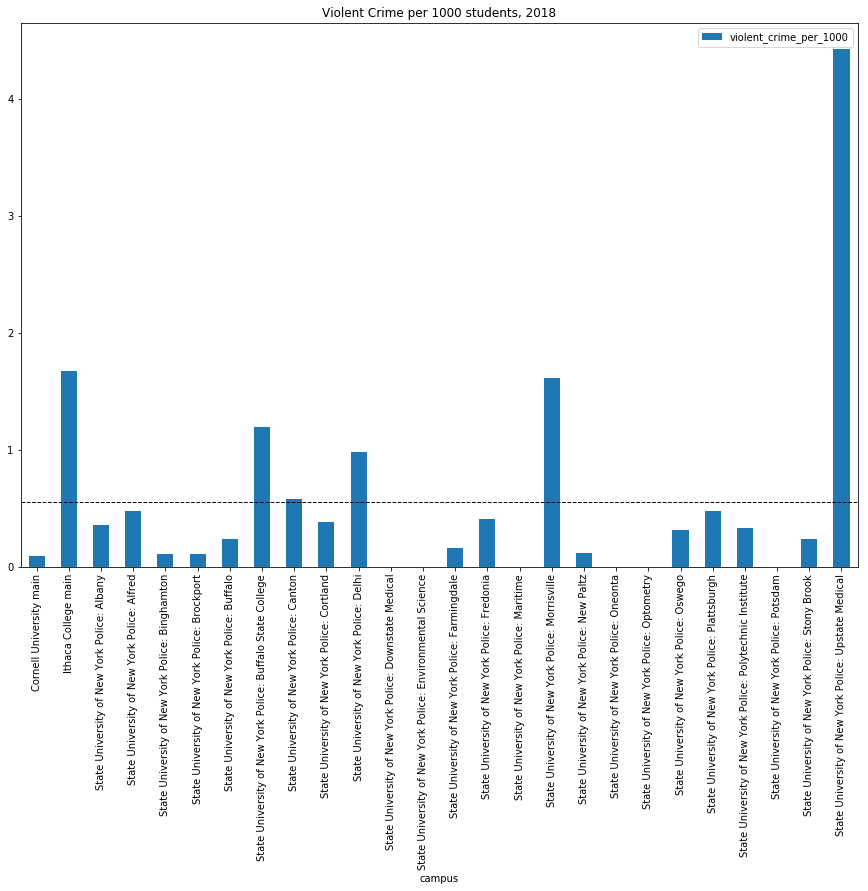

In [12]:
df_2018 = pd.read_excel('Table_9_Offenses_Known_to_Law_Enforcement_by_State_by_University_and_College_2018.xls',header=1, skiprows=2)
r, c = df_2018.shape
print('There are',r,'rows and',c,'columns in the 2018 FULL data')

df_2018.columns = df_2018.columns.str.strip().str.lower().str.replace('\n',' ').str.replace(' ', '_').str.replace('(', '').str.replace(')', '')

df_2018['state'].fillna(method='ffill',inplace=True)
df_2018['university/college'].fillna(method='ffill',inplace=True)
#df_2018['campus'].fillna(df_2018['university/college'],inplace=True)
df_2018['campus'].fillna('main',inplace=True)
df_2018['campus'] = df_2018['university/college'] + ' ' + df_2018['campus']
df_2018.fillna(0,inplace=True)

nys_df_2018 = df_2018.loc[df_2018['state'] == "NEW YORK"].copy()
nys_df_2018['campus'] = nys_df_2018['campus'].str.replace('5','')

nys_df_2018['violent_crime_per_1000'] =  (nys_df_2018['violent_crime'] / (nys_df_2018['student_enrollment1'] / 1000) )

r, c = nys_df_2018.shape
print('There are',r,'rows and',c,'columns in the 2018 NYS data')

mean_vcp_2018 = nys_df_2018['violent_crime_per_1000'].mean()
median_vcp_2018 = nys_df_2018['violent_crime_per_1000'].median()
max_vc = nys_df_2018['violent_crime_per_1000'].max()
min_vc = nys_df_2018['violent_crime_per_1000'].min()

print('For NYS, mean average crime per 1000 is',mean_vcp_2018,'( median:',median_vcp_2018,')')
print('MAX:',max_vc,'and MIN:',min_vc)
print()
#print('The row with highest violent crime per 1000 people is:\n\n',nys_df_2018.loc[nys_df_2018['violent_crime_per_1000'].idxmax()])

nys_df_2018.plot.bar(x='campus', y='violent_crime_per_1000', rot=0,figsize=(15,10))
plt.axhline(y=mean_vcp_2018,linewidth=1, color='k', linestyle='--')

plt.title('Violent Crime per 1000 students, 2018')
plt.xticks(rotation=90)
plt.show()


### Combined years data analysis

Let's take a look at the mean and median number of violent crimes at Universities and Colleges, per 1000 students, over the five year period.

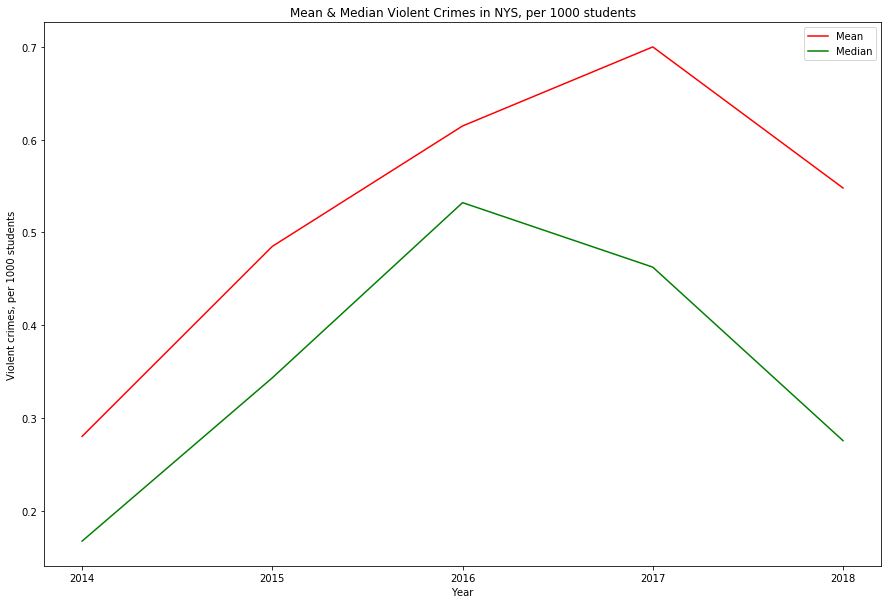

In [13]:
import numpy as np

mean_data = [mean_vcp_2014,mean_vcp_2015,mean_vcp_2016,mean_vcp_2017,mean_vcp_2018]
median_data = [median_vcp_2014,median_vcp_2015,median_vcp_2016,median_vcp_2017,median_vcp_2018]

X = range(len(mean_data))

plt.rcParams["figure.figsize"] = (15,10)
plt.plot(X, mean_data, 'r',label='Mean')
plt.plot(X, median_data, 'g',label='Median')
plt.xticks(np.arange(5), ('2014', '2015', '2016', '2017', '2018'))
plt.title('Mean & Median Violent Crimes in NYS, per 1000 students')
plt.xlabel('Year')
plt.ylabel('Violent crimes, per 1000 students')
plt.legend()
plt.show()



Now we slice the data to combine it across all five years. This is going to reveal a problem. As is typical in data, it turns out that the names of some of the schools have changed over time, or are represented slightly differently between years. We do not resolve this here.

Any entry in the data below where an NaN appears means that there isn't a value for that entry for the given year. This can be because of changes in naming, or because data for that year is not included in the source files.

This leaves us with a data set with some 61 rows. This confirms our fears, because each of the data sets above have been 26 to 30 rows. The fact that there are 61 rows below means that there are issues combining the data, resulting in spurious unique rows. For instance, we suspect row 55 and row 60 to represent the same institution with minor grammatical differences. Again this is not resolved here. 

In [14]:
from functools import reduce


df_2018 = nys_df_2018[['campus','violent_crime_per_1000']].copy()
df_2017 = nys_df_2017[['campus','violent_crime_per_1000']].copy()
df_2016 = nys_df_2016[['campus','violent_crime_per_1000']].copy()
df_2015 = nys_df_2015[['campus','violent_crime_per_1000']].copy()
df_2014 = nys_df_2014[['campus','violent_crime_per_1000']].copy()


df_2018.rename(columns = {'violent_crime_per_1000':'2018'}, inplace = True)
df_2017.rename(columns = {'violent_crime_per_1000':'2017'}, inplace = True)
df_2016.rename(columns = {'violent_crime_per_1000':'2016'}, inplace = True)
df_2015.rename(columns = {'violent_crime_per_1000':'2015'}, inplace = True)
df_2014.rename(columns = {'violent_crime_per_1000':'2014'}, inplace = True)

frames = [df_2014,df_2015,df_2016,df_2017,df_2018]

df_merged = reduce(lambda  left,right: pd.merge(left,right,on=['campus'],
                                            how='outer'), frames)

df_merged

,campus,2014,2015,2016,2017,2018
0,Cornell University main,0.185245,0.138383,0.319576,0.134415,0.087642
1,Ithaca College main,0.148743,0.759071,1.477323,1.647200,1.670379
2,State University of New York: Binghamton,0.062201,0.479185,0.532135,NaN,NaN
3,State University of New York: Buffalo,0.167504,0.333389,0.335616,NaN,NaN
4,State University of New York: Downstate Medic...,0.000000,2.144772,0.538213,NaN,NaN
5,State University of New York: Maritime College,0.000000,0.000000,0.000000,NaN,NaN
6,State University of New York: Stony Brook,0.331359,0.406388,0.553973,NaN,NaN
7,State University of New York: Upstate Medical...,1.236858,0.000000,1.351351,NaN,NaN
8,State University of New York Agricultural and ...,0.562588,0.819448,0.811030,NaN,NaN
9,State University of New York Agricultural and ...,0.000000,0.305064,0.955414,NaN,NaN


Rather than fix the data merging problems above, we slice out just the fist two rows dealing with Cornell and Ithaca College, and graph the results over the five year time period.

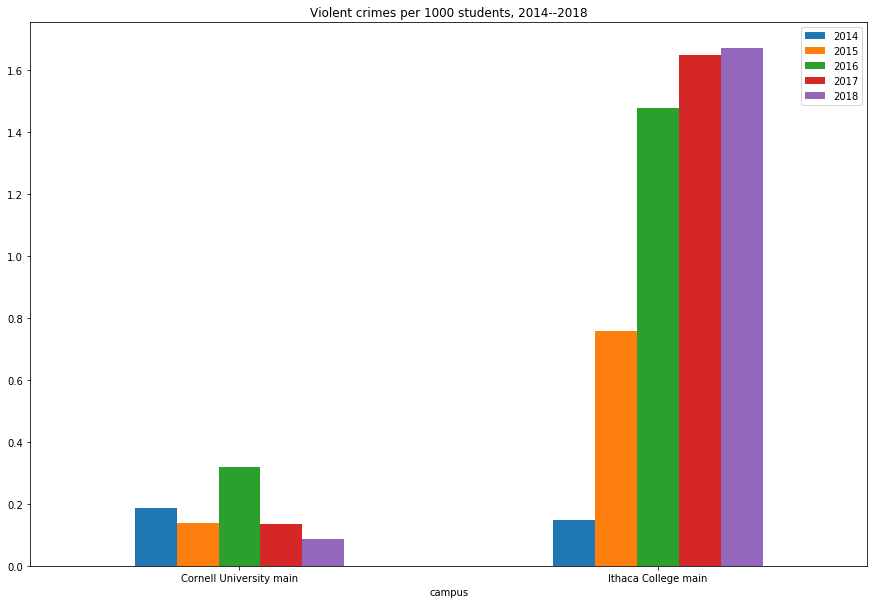

In [15]:

# select just the first two rows
# and plot them


df_sub = df_merged[0:2]
df_sub.plot.bar(x='campus', rot=0,figsize=(15,10))
plt.title('Violent crimes per 1000 students, 2014--2018')
plt.show()

### Law Enforcement at Colleges and Universities Data - 2018

There are other tables in the data, detailing the number of law enforcement employees at Universities and Colleges. We read in this data, and perform the same data formatting as the crime statistics data.

In [16]:
lee_2018 = pd.read_excel('Table_79_Full_time_Law_Enforcement_Employees_by_State_by_University_and_College_2018.xls',header=1, skiprows=2)


# Get some details about how much data there is

r, c = lee_2018.shape
print('There are',r,'rows and',c,'columns in this data')


# Adjust the column headings to something more uniform
# Used print(lee_2018.columns.values.tolist())
# to show original headings

lee_2018.columns = lee_2018.columns.str.strip().str.lower().str.replace('\n',' ').str.replace(' ', '_').str.replace('(', '').str.replace(')', '')
 

lee_2018['state'].fillna(method='ffill',inplace=True)
lee_2018['university/college'].fillna(method='ffill',inplace=True)
#lee_2018['campus'].fillna(lee_2018['university/college'],inplace=True)
lee_2018['campus'].fillna('main',inplace=True)
lee_2018['campus'] = lee_2018['university/college'] + ' ' + lee_2018['campus']
lee_2018.fillna(0,inplace=True)

# Show results

lee_2018.head()


There are 663 rows and 7 columns in this data


,state,university/college,campus,student_enrollment1,total_law_enforcement__employees,total_officers,total_civilians
0,ALABAMA,Alabama A&M University,Alabama A&M University main,6392.0,41.0,16.0,25.0
1,ALABAMA,Alabama State University,Alabama State University main,5916.0,30.0,24.0,6.0
2,ALABAMA,Auburn University,Auburn University Montgomery,5775.0,22.0,14.0,8.0
3,ALABAMA,Bevill State Community College,Bevill State Community College main,5505.0,4.0,2.0,2.0
4,ALABAMA,Bishop State Community College,Bishop State Community College main,4763.0,7.0,7.0,0.0


As with the violent crime data, we add a column that represents the number of law enforcement employees, per 1000 students.

In [17]:
nys_lee_2018 = lee_2018.loc[lee_2018['state'] == "NEW YORK"].copy()
nys_lee_2018['campus'] = nys_lee_2018['campus'].str.replace('5','')

nys_lee_2018['employees_per_1000'] =  (nys_lee_2018['total_law_enforcement__employees'] / (nys_lee_2018['student_enrollment1'] / 1000) )

nys_lee_2018.head()


,state,university/college,campus,student_enrollment1,total_law_enforcement__employees,total_officers,total_civilians,employees_per_1000
371,NEW YORK,Cornell University,Cornell University main,22820.0,68.0,45.0,23.0,2.979842
372,NEW YORK,Ithaca College,Ithaca College main,7184.0,41.0,23.0,18.0,5.707127
373,NEW YORK,State University of New York Police:,State University of New York Police: Albany,19834.0,59.0,40.0,19.0,2.974690
374,NEW YORK,State University of New York Police:,State University of New York Police: Alfred,4198.0,16.0,11.0,5.0,3.811339
375,NEW YORK,State University of New York Police:,State University of New York Police: Binghamton,18758.0,57.0,42.0,15.0,3.038703


### Combined data for 2018

We now combine the data on law enforcement employees (from above) and violent crimes (from earlier), for the year 2018.

In [18]:
le_2018 = nys_lee_2018[['campus','employees_per_1000']].copy()

frames = [df_2018,le_2018]

df_le_vc = reduce(lambda  left,right: pd.merge(left,right,on=['campus'],
                                            how='outer'), frames)

df_le_vc.dropna(inplace=True)

df_le_vc

,campus,2018,employees_per_1000
0,Cornell University main,0.087642,2.979842
1,Ithaca College main,1.670379,5.707127
2,State University of New York Police: Albany,0.352929,2.974690
3,State University of New York Police: Alfred,0.476417,3.811339
4,State University of New York Police: Binghamton,0.106621,3.038703
5,State University of New York Police: Brockport,0.107066,2.355460
6,State University of New York Police: Buffalo,0.237763,2.258745
7,State University of New York Police: Buffalo S...,1.190694,3.297307
8,State University of New York Police: Canton,0.578815,1.929385
9,State University of New York Police: Cortland,0.383289,3.321835


### Learning relationships

To now we haven't performed any specific analytics. I'm going to run a baseline machine learning classifier (ZeroR) on the employee numbers to see if we can 'predict' the number of crimes per 1000 people. ZeroR simply takes the mean of the number of crimes, and predicts that value uniformly. 

To attempt to improve on that, I'm using a linear regression model. 

Both results are presented as RMSE (Root Mean Squared Error), and plotting the lines of best fit. 

Regression RMSE: 0.7566220819741319
ZeroR RMSE: 1.055946126010569


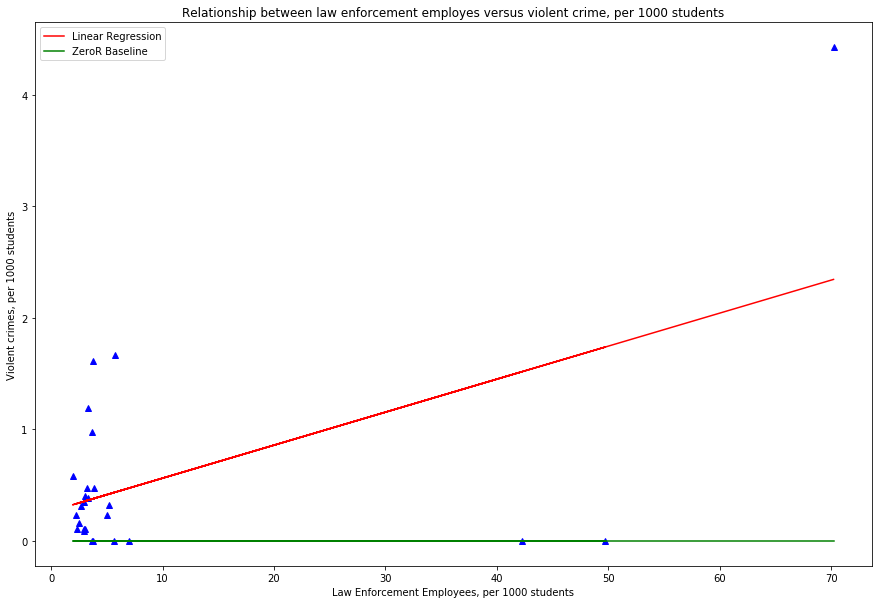

In [19]:
from sklearn.linear_model import LinearRegression
from sklearn.dummy import DummyClassifier
from sklearn.metrics import mean_squared_error
import math


df = df_le_vc[['employees_per_1000','2018']]

array = df.values
X = array[:,0:1]
y = array[:,1]

zR = DummyClassifier(strategy="most_frequent")
zeroR = zR.fit(X,y)
zr_predY = zeroR.predict(X)

lr = LinearRegression()
reg = lr.fit(X,y)

predY = reg.predict(X)


lr_rmse = math.sqrt(mean_squared_error(y,predY))
zr_rmse = math.sqrt(mean_squared_error(y,zr_predY))


print('Regression RMSE:',lr_rmse)
print('ZeroR RMSE:',zr_rmse)


plt.rcParams["figure.figsize"] = (15,10)
plt.plot(X, y,'b^')
plt.plot(X, predY, 'r',label='Linear Regression')
plt.plot(X, zr_predY, 'g',label='ZeroR Baseline')
plt.title('Relationship between law enforcement employes versus violent crime, per 1000 students')
plt.xlabel('Law Enforcement Employees, per 1000 students')
plt.ylabel('Violent crimes, per 1000 students')
plt.legend()
plt.show()

### Conclusions

The linear regression model is an improvement in using law enforcement numbers to predict violent crimes, to the tune of one quarter of a violent crime per 1000 students increase in accuracy (0.76 vs 1.06). There are MANY problems with this analysis:

- correlation vs. causation
- using the same data for training and testing hopelessly overestimates performance
- using such a small sample of data

But as an indication of what we do and how it works, this is a quick overview. A final note. We decided to look at the mean and median numbers of law enforcement employees on University and College campuses in NY state, and graph that over the five year time period. We first repeat the graph of crimes from earlier, and then follow it with the graph of employees. Note that these graphs are on different scales. 

In [20]:
lee_2017 = pd.read_excel('Table_79_Full_time_Law_Enforcement_Employees_by_State_by_University_and_College_2017.xls',header=1, skiprows=2)
lee_2017.columns = lee_2017.columns.str.strip().str.lower().str.replace('\n',' ').str.replace(' ', '_').str.replace('(', '').str.replace(')', '')
lee_2017['state'].fillna(method='ffill',inplace=True)
lee_2017['university/college'].fillna(method='ffill',inplace=True)
lee_2017['campus'].fillna('main',inplace=True)
lee_2017['campus'] = lee_2017['university/college'] + ' ' + lee_2017['campus']
lee_2017.fillna(0,inplace=True)
nys_lee_2017 = lee_2017.loc[lee_2017['state'] == "NEW YORK"].copy()
nys_lee_2017['campus'] = nys_lee_2017['campus'].str.replace('5','')
nys_lee_2017['employees_per_1000'] =  (nys_lee_2017['total_law_enforcement__employees'] / (nys_lee_2017['student_enrollment1'] / 1000) )

In [21]:
lee_2016 = pd.read_excel('Table_27_Full_time_Law_Enforcement_Employees_by_State_by_University_and_College_2016.xls',header=1, skiprows=2)
lee_2016.columns = lee_2016.columns.str.strip().str.lower().str.replace('\n',' ').str.replace(' ', '_').str.replace('(', '').str.replace(')', '')
lee_2016['state'].fillna(method='ffill',inplace=True)
lee_2016['university/college'].fillna(method='ffill',inplace=True)
lee_2016['campus'].fillna('main',inplace=True)
lee_2016['campus'] = lee_2016['university/college'] + ' ' + lee_2016['campus']
lee_2016.fillna(0,inplace=True)
nys_lee_2016 = lee_2016.loc[lee_2016['state'] == "NEW YORK"].copy()
nys_lee_2016['campus'] = nys_lee_2016['campus'].str.replace('5','')
nys_lee_2016['employees_per_1000'] =  (nys_lee_2016['total_law_enforcement__employees'] / (nys_lee_2016['student_enrollment1'] / 1000) )

In [22]:
lee_2015 = pd.read_excel('Table_79_Full_time_Law_Enforcement_Employees_by_State_by_University_and_College_2015.xls',header=1, skiprows=2)
lee_2015.columns = lee_2015.columns.str.strip().str.lower().str.replace('\n',' ').str.replace(' ', '_').str.replace('(', '').str.replace(')', '')
lee_2015['state'].fillna(method='ffill',inplace=True)
lee_2015['university/college'].fillna(method='ffill',inplace=True)
lee_2015['campus'].fillna('main',inplace=True)
lee_2015['campus'] = lee_2015['university/college'] + ' ' + lee_2015['campus']
lee_2015.fillna(0,inplace=True)
nys_lee_2015 = lee_2015.loc[lee_2015['state'] == "NEW YORK"].copy()
nys_lee_2015['campus'] = nys_lee_2015['campus'].str.replace('5','')
nys_lee_2015['employees_per_1000'] =  (nys_lee_2015['total_law_enforcement__employees'] / (nys_lee_2015['student_enrollment1'] / 1000) )

In [23]:
lee_2014 = pd.read_excel('Table_79_Full_time_Law_Enforcement_Employees_by_State_by_University_and_College_2014.xls',header=1, skiprows=2)
lee_2014.columns = lee_2014.columns.str.strip().str.lower().str.replace('\n',' ').str.replace(' ', '_').str.replace('(', '').str.replace(')', '')
lee_2014['state'].fillna(method='ffill',inplace=True)
lee_2014['university/college'].fillna(method='ffill',inplace=True)
lee_2014['campus'].fillna('main',inplace=True)
lee_2014['campus'] = lee_2014['university/college'] + ' ' + lee_2014['campus']
lee_2014.fillna(0,inplace=True)
nys_lee_2014 = lee_2014.loc[lee_2014['state'] == "NEW YORK"].copy()
nys_lee_2014['campus'] = nys_lee_2014['campus'].str.replace('5','')
nys_lee_2014['employees_per_1000'] =  (nys_lee_2014['total_law_enforcement__employees'] / (nys_lee_2014['student_enrollment1'] / 1000) )

In [24]:
mean_lee_2018 = nys_lee_2018['employees_per_1000'].mean()
median_lee_2018 = nys_lee_2018['employees_per_1000'].median()
mean_lee_2017 = nys_lee_2017['employees_per_1000'].mean()
median_lee_2017 = nys_lee_2017['employees_per_1000'].median()
mean_lee_2016 = nys_lee_2016['employees_per_1000'].mean()
median_lee_2016 = nys_lee_2016['employees_per_1000'].median()
mean_lee_2015 = nys_lee_2015['employees_per_1000'].mean()
median_lee_2015 = nys_lee_2015['employees_per_1000'].median()
mean_lee_2014 = nys_lee_2014['employees_per_1000'].mean()
median_lee_2014 = nys_lee_2014['employees_per_1000'].median()

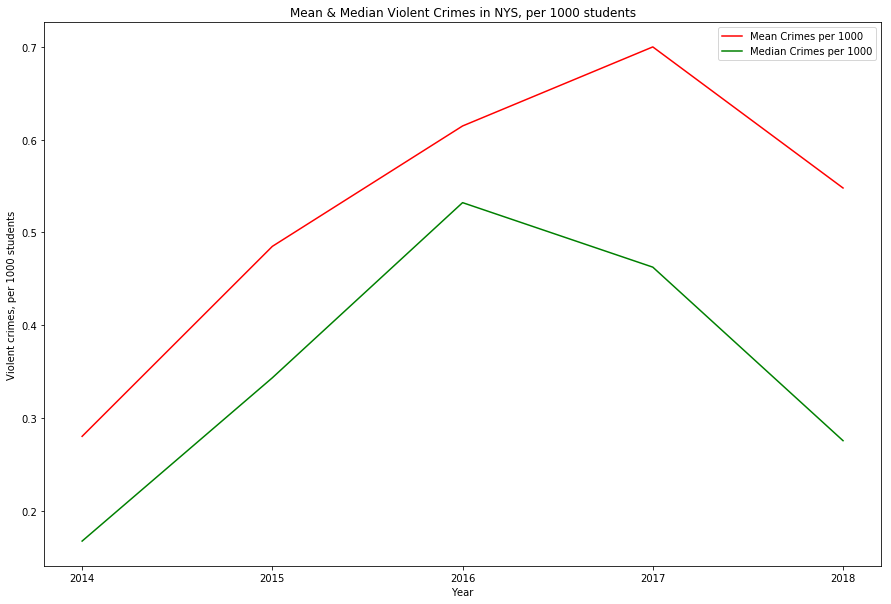

In [25]:
mean_lee_data = [mean_lee_2014,mean_lee_2015,mean_lee_2016,mean_lee_2017,mean_lee_2018]
median_lee_data = [median_lee_2014,median_lee_2015,median_lee_2016,median_lee_2017,median_lee_2018]

X = range(len(mean_lee_data))

plt.rcParams["figure.figsize"] = (15,10)
plt.plot(X, mean_data, 'r',label='Mean Crimes per 1000')
plt.plot(X, median_data, 'g',label='Median Crimes per 1000')
plt.xticks(np.arange(5), ('2014', '2015', '2016', '2017', '2018'))
plt.title('Mean & Median Violent Crimes in NYS, per 1000 students')
plt.xlabel('Year')
plt.ylabel('Violent crimes, per 1000 students')
plt.legend()
plt.show()


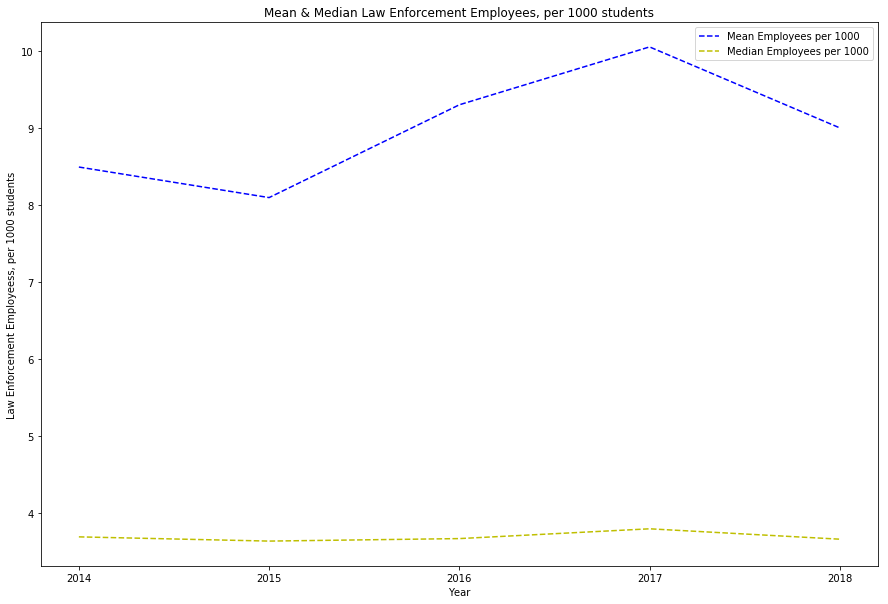

In [26]:
plt.rcParams["figure.figsize"] = (15,10)
plt.plot(X, mean_lee_data, 'b--',label='Mean Employees per 1000')
plt.plot(X, median_lee_data, 'y--',label='Median Employees per 1000')
plt.xticks(np.arange(5), ('2014', '2015', '2016', '2017', '2018'))
plt.title('Mean & Median Law Enforcement Employees, per 1000 students')
plt.xlabel('Year')
plt.ylabel('Law Enforcement Employeess, per 1000 students')
plt.legend()
plt.show()